In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

# Load the dataset
df = pd.read_csv('Database.csv')

# Convert Time to datetime
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d-T%H:%M')

print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nBasic Statistics:")
print(df.describe())

Dataset Info:
Shape: (38879, 13)
Columns: ['Unnamed: 0', 'Time', 'Season', 'Day_of_the_week', 'DHI', 'DNI', 'GHI', 'Wind_speed', 'Humidity', 'Temperature', 'PV_production', 'Wind_production', 'Electric_demand']

Basic Statistics:
         Unnamed: 0                 Time        Season  Day_of_the_week  \
count  38879.000000                38879  38879.000000     38879.000000   
mean   19439.000000  2019-03-09 11:55:00      1.333316         2.977803   
min        0.000000  2019-01-01 00:00:00      1.000000         0.000000   
25%     9719.500000  2019-02-03 17:57:30      1.000000         1.000000   
50%    19439.000000  2019-03-09 11:55:00      1.000000         3.000000   
75%    29158.500000  2019-04-12 05:52:30      2.000000         5.000000   
max    38878.000000  2019-05-15 23:50:00      2.000000         6.000000   
std    11223.544895                  NaN      0.471405         1.994358   

                DHI           DNI           GHI    Wind_speed      Humidity  \
count  38879.00

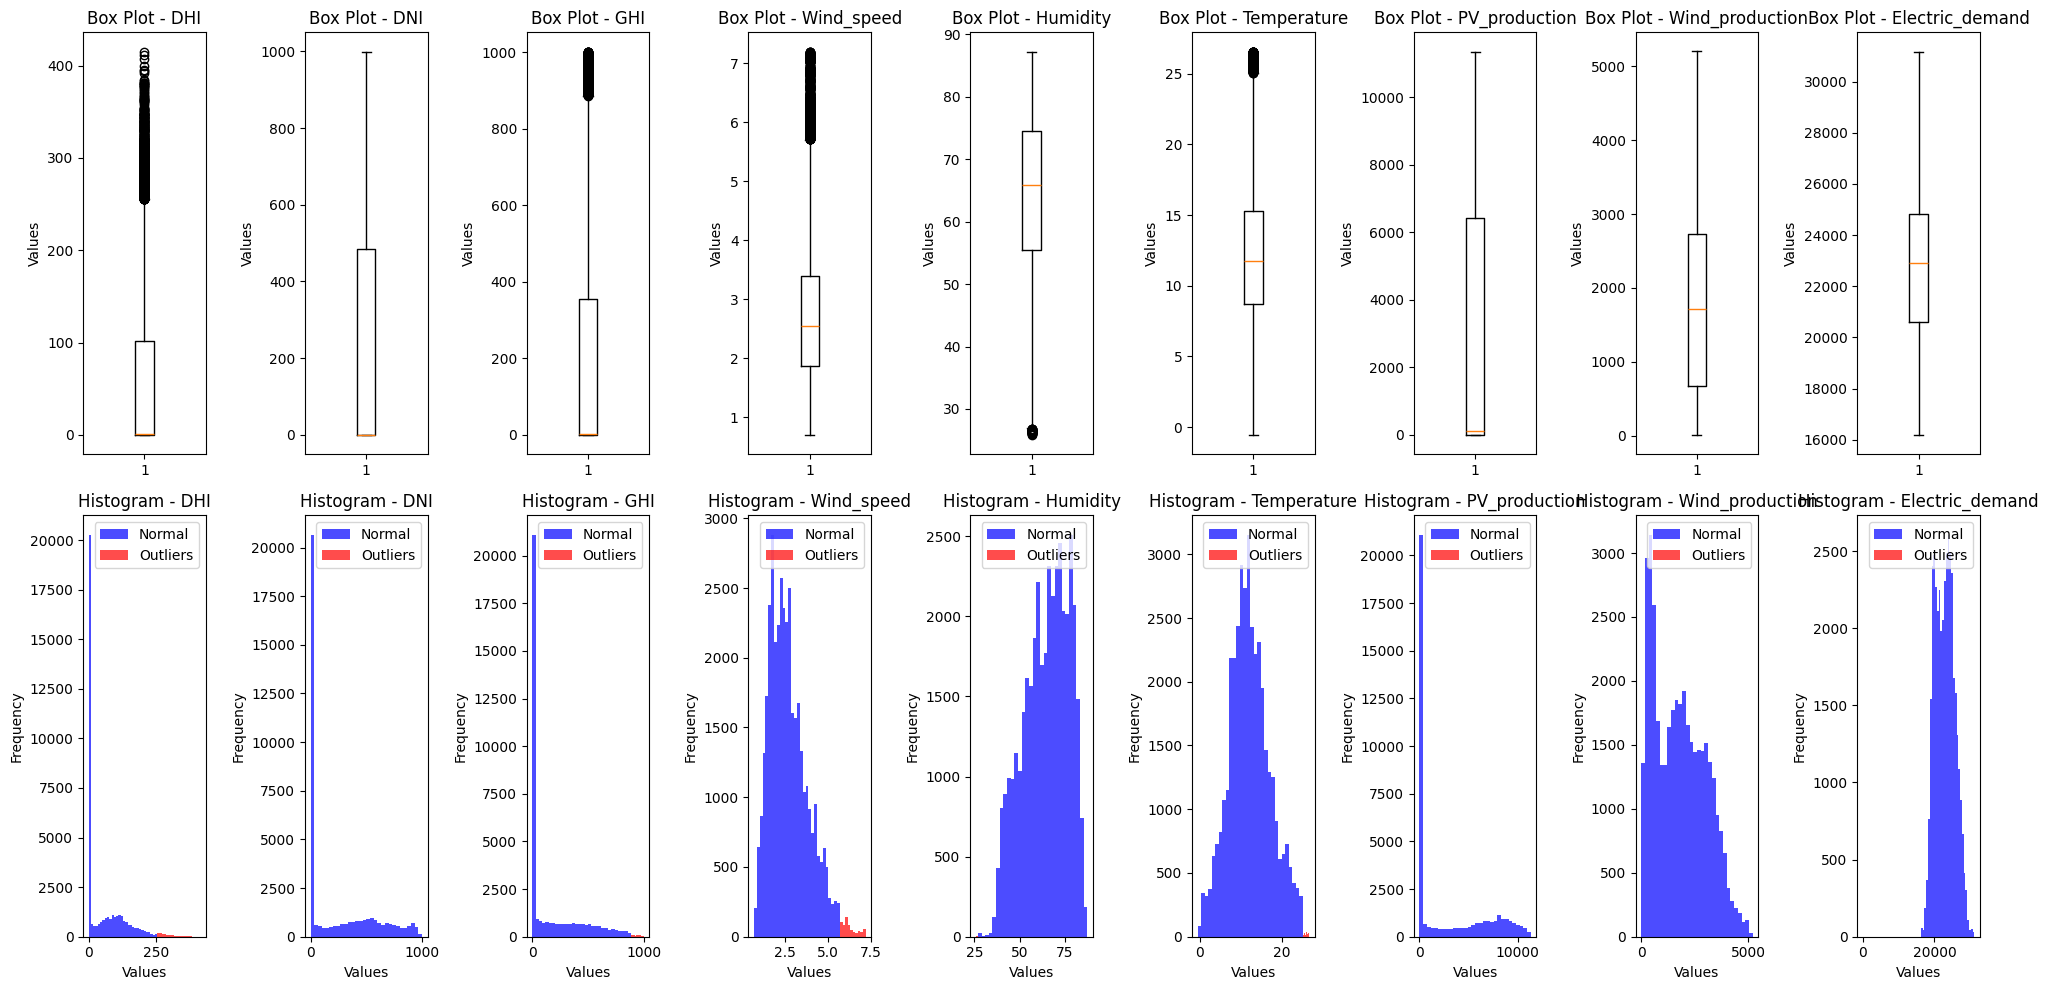

In [2]:
def create_outlier_detection_plots(df, numerical_cols):
    """
    Create comprehensive plots to identify outliers
    """
    n_cols = len(numerical_cols)
    fig, axes = plt.subplots(2, n_cols, figsize=(20, 10))
    
    for i, col in enumerate(numerical_cols):
        # Box plot (better for outlier detection)
        axes[0, i].boxplot(df[col].dropna())
        axes[0, i].set_title(f'Box Plot - {col}')
        axes[0, i].set_ylabel('Values')
        
        # Histogram with outlier indication
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Color outliers differently in histogram
        non_outliers = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)][col]
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        
        axes[1, i].hist(non_outliers, bins=30, alpha=0.7, label='Normal', color='blue')
        axes[1, i].hist(outliers, bins=10, alpha=0.7, label='Outliers', color='red')
        axes[1, i].set_title(f'Histogram - {col}')
        axes[1, i].set_xlabel('Values')
        axes[1, i].set_ylabel('Frequency')
        axes[1, i].legend()
    
    plt.tight_layout()
    plt.savefig('outlier_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Define numerical columns
numerical_cols = ['DHI', 'DNI', 'GHI', 'Wind_speed', 'Humidity', 
                  'Temperature', 'PV_production', 'Wind_production', 'Electric_demand']

create_outlier_detection_plots(df, numerical_cols)

In [3]:
def analyze_and_remove_outliers(df, numerical_cols, method='iqr', threshold=3.0):
    """
    Advanced outlier detection and removal
    
    Parameters:
    - method: 'iqr' or 'zscore'
    - threshold: sensitivity for outlier detection
    """
    df_clean = df.copy()
    
    print("OUTLIER ANALYSIS REPORT:")
    print("=" * 50)
    
    outliers_info = {}
    
    for col in numerical_cols:
        original_count = len(df_clean)
        
        if method == 'iqr':
            # IQR Method (Robust to non-normal distributions)
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            # Identify outliers
            outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
            
        elif method == 'zscore':
            # Z-score Method (Good for normal distributions)
            z_scores = np.abs(stats.zscore(df_clean[col].dropna()))
            outliers = df_clean[z_scores > threshold]
        
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / original_count) * 100
        
        outliers_info[col] = {
            'outlier_count': outlier_count,
            'percentage': outlier_percentage,
            'lower_bound': lower_bound if method == 'iqr' else None,
            'upper_bound': upper_bound if method == 'iqr' else None
        }
        
        print(f"{col}:")
        print(f"  - Outliers: {outlier_count} ({outlier_percentage:.2f}%)")
        if method == 'iqr':
            print(f"  - Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
        
        # Remove outliers
        if method == 'iqr':
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
        elif method == 'zscore':
            df_clean = df_clean[z_scores <= threshold]
    
    print(f"\nOriginal dataset shape: {df.shape}")
    print(f"Cleaned dataset shape: {df_clean.shape}")
    print(f"Removed {len(df) - len(df_clean)} rows total")
    
    return df_clean, outliers_info

# Apply outlier removal
df_clean, outlier_report = analyze_and_remove_outliers(df, numerical_cols, method='iqr', threshold=3.5)

OUTLIER ANALYSIS REPORT:
DHI:
  - Outliers: 0 (0.00%)
  - Bounds: [-357.00, 459.00]
DNI:
  - Outliers: 0 (0.00%)
  - Bounds: [-1694.70, 2178.90]
GHI:
  - Outliers: 0 (0.00%)
  - Bounds: [-1241.10, 1595.70]
Wind_speed:
  - Outliers: 0 (0.00%)
  - Bounds: [-3.53, 8.79]
Humidity:
  - Outliers: 0 (0.00%)
  - Bounds: [-11.16, 140.99]
Temperature:
  - Outliers: 0 (0.00%)
  - Bounds: [-14.08, 38.08]
PV_production:
  - Outliers: 0 (0.00%)
  - Bounds: [-22470.00, 28890.00]
Wind_production:
  - Outliers: 0 (0.00%)
  - Bounds: [-6564.50, 9971.50]
Electric_demand:
  - Outliers: 0 (0.00%)
  - Bounds: [5733.50, 39693.50]

Original dataset shape: (38879, 13)
Cleaned dataset shape: (38879, 13)
Removed 0 rows total


In [4]:
def should_normalize_data(df, numerical_cols):
    """
    Analyze if normalization is needed
    """
    print("\nNORMALIZATION ANALYSIS:")
    print("=" * 50)
    
    needs_normalization = False
    reasons = []
    
    for col in numerical_cols:
        data = df[col].dropna()
        
        # Check 1: Range of values
        value_range = data.max() - data.min()
        if value_range > 1000:  # Arbitrary threshold for large ranges
            reasons.append(f"{col}: Large value range ({value_range:.2f})")
            needs_normalization = True
        
        # Check 2: Standard deviation relative to mean
        cv = data.std() / data.mean() if data.mean() != 0 else float('inf')
        if cv > 1.0:  # High coefficient of variation
            reasons.append(f"{col}: High coefficient of variation ({cv:.2f})")
            needs_normalization = True
        
        # Check 3: Different units/scales
        print(f"{col}: min={data.min():.2f}, max={data.max():.2f}, mean={data.mean():.2f}, std={data.std():.2f}")
    
    print(f"\nNormalization needed: {needs_normalization}")
    if needs_normalization and reasons:
        print("Reasons:")
        for reason in reasons:
            print(f"  - {reason}")
    
    return needs_normalization

# Check if normalization is needed
normalization_needed = should_normalize_data(df_clean, numerical_cols)


NORMALIZATION ANALYSIS:
DHI: min=0.00, max=415.20, mean=54.32, std=72.15
DNI: min=0.00, max=999.80, mean=237.84, std=305.68
GHI: min=0.00, max=1001.60, mean=189.02, std=265.92
Wind_speed: min=0.70, max=7.20, mean=2.74, std=1.15
Humidity: min=25.86, max=87.23, mean=64.39, std=12.28
Temperature: min=-0.54, max=26.56, mean=12.17, std=5.09
PV_production: min=0.00, max=11350.00, mean=2895.53, std=3707.72
Wind_production: min=10.00, max=5203.00, mean=1804.25, std=1187.63
Electric_demand: min=16190.00, max=31173.00, mean=22880.41, std=2707.44

Normalization needed: True
Reasons:
  - DHI: High coefficient of variation (1.33)
  - DNI: High coefficient of variation (1.29)
  - GHI: Large value range (1001.60)
  - GHI: High coefficient of variation (1.41)
  - PV_production: Large value range (11350.00)
  - PV_production: High coefficient of variation (1.28)
  - Wind_production: Large value range (5193.00)
  - Electric_demand: Large value range (14983.00)


In [5]:
def smart_normalization(df, numerical_cols, target_columns=None):
    """
    Apply appropriate normalization based on data characteristics
    """
    df_normalized = df.copy()
    
    if target_columns is None:
        target_columns = ['PV_production', 'Wind_production', 'Electric_demand']
    
    # Separate features and targets
    feature_columns = [col for col in numerical_cols if col not in target_columns]
    
    print("\nAPPLYING NORMALIZATION:")
    print("=" * 50)
    
    # Normalize features (always good practice)
    feature_scaler = MinMaxScaler()
    df_normalized[feature_columns] = feature_scaler.fit_transform(df_normalized[feature_columns])
    print("- Features normalized using MinMaxScaler")
    
    # For target variables, we might want to keep original scale for interpretation
    # But we'll create normalized versions for modeling
    target_scaler = MinMaxScaler()
    for target in target_columns:
        if target in numerical_cols:
            df_normalized[f'{target}_normalized'] = target_scaler.fit_transform(
                df_normalized[[target]]
            )
            print(f"- Created normalized version: {target}_normalized")
    
    return df_normalized, feature_scaler, target_scaler

# Apply smart normalization
df_final, feature_scaler, target_scaler = smart_normalization(df_clean, numerical_cols)

print(f"\nFinal dataset shape: {df_final.shape}")
print("\nFirst 5 rows of processed data:")
print(df_final.head())


APPLYING NORMALIZATION:
- Features normalized using MinMaxScaler
- Created normalized version: PV_production_normalized
- Created normalized version: Wind_production_normalized
- Created normalized version: Electric_demand_normalized

Final dataset shape: (38879, 16)

First 5 rows of processed data:
   Unnamed: 0                Time  Season  Day_of_the_week  DHI  DNI  GHI  \
0           0 2019-01-01 00:00:00       1                1  0.0  0.0  0.0   
1           1 2019-01-01 00:05:00       1                1  0.0  0.0  0.0   
2           2 2019-01-01 00:10:00       1                1  0.0  0.0  0.0   
3           3 2019-01-01 00:15:00       1                1  0.0  0.0  0.0   
4           4 2019-01-01 00:20:00       1                1  0.0  0.0  0.0   

   Wind_speed  Humidity  Temperature  PV_production  Wind_production  \
0    0.335385  0.491738     0.087085              0             2810   
1    0.335385  0.491738     0.087085              0             2862   
2    0.335385  0.49

In [6]:
# Save the processed data
df_final.to_csv("preprocess_data.csv", index=False)

# Create a summary report
with open("preprocessing_report.txt", "w") as f:
    f.write("RENEWABLE ENERGY DATA PREPROCESSING REPORT\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Original dataset size: {df.shape}\n")
    f.write(f"Final dataset size: {df_final.shape}\n")
    f.write(f"Rows removed: {len(df) - len(df_final)}\n\n")
    
    f.write("OUTLIER SUMMARY:\n")
    for col, info in outlier_report.items():
        f.write(f"{col}: {info['outlier_count']} outliers ({info['percentage']:.2f}%)\n")
    
    f.write(f"\nNormalization applied: Yes\n")
    f.write("Features normalized: All input features\n")
    f.write("Target variables: Original + normalized versions created\n")

print("Processing complete!")
print("- improved_preprocessed_data.csv - Final processed dataset")
print("- preprocessing_report.txt - Detailed analysis report")
print("- outlier_analysis.png - Visual outlier detection plots")

Processing complete!
- improved_preprocessed_data.csv - Final processed dataset
- preprocessing_report.txt - Detailed analysis report
- outlier_analysis.png - Visual outlier detection plots
